# Richard is an idiot

Okay, further to our pub discussion, here is an example of the two strange types of behaviour I mentioned. I've labelled the problem of subsampling curves Mystery 1, and the problem of constant curves far from 0 as Mystery 2. I'm less concerned by mystery 1, and accept it may just be a quirk that makes sense when we think harder. Mystery 2 still puzzles me, so perhaps skip mystery 1 if you don't have time.

Any thoughts you have would be welcomed. I've checked the eigenvalues, and they don't appear too badly behaved to me.

In [1]:
import GPy
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

Let's begin by setting up a covariance matrix, and sampling some curves from a multivariate normal distribution. I use points equally spaced in $[0,1]$. I've initially created a covariance matrix using a Matern 3/2 cov function plus a healthy nugget on the diagonal.

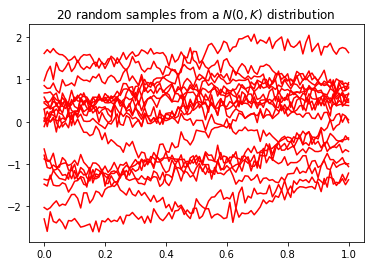

In [2]:
x = np.linspace(0,1,101)[:,None]
k = GPy.kern.Matern32(1, lengthscale=1)+GPy.kern.White(1, variance=0.01)
K = k.K(x)
f_samples = np.random.multivariate_normal(np.zeros(x.size), K, 20)

for ii in np.arange(20):
    plt.plot(x, f_samples[ii,:], 'r')
    plt.title("20 random samples from a $N(0, K)$ distribution ")

Following Ian's suggestion, let's check the eigenvalues of this matrix.

In [3]:
w,v = np.linalg.eig(K)
w

array([8.76719996e+01, 1.11669302e+01, 1.61396804e+00, 3.71962878e-01,
       1.25173411e-01, 5.62301700e-02, 3.17674980e-02, 2.14906229e-02,
       1.66051387e-02, 1.40544731e-02, 1.26216473e-02, 1.17681516e-02,
       1.12347663e-02, 1.08878524e-02, 1.06544779e-02, 1.04928849e-02,
       1.03781652e-02, 1.02949260e-02, 1.02333569e-02, 1.01870330e-02,
       1.01516444e-02, 1.01242371e-02, 1.01027467e-02, 1.00857057e-02,
       1.00720536e-02, 1.00610136e-02, 1.00520086e-02, 1.00446049e-02,
       1.00384728e-02, 1.00333592e-02, 1.00290679e-02, 1.00254452e-02,
       1.00223700e-02, 1.00197461e-02, 1.00174963e-02, 1.00155584e-02,
       1.00138820e-02, 1.00124260e-02, 1.00111565e-02, 1.00100455e-02,
       1.00090700e-02, 1.00082106e-02, 1.00074512e-02, 1.00067781e-02,
       1.00061798e-02, 1.00056467e-02, 1.00051704e-02, 1.00047438e-02,
       1.00043609e-02, 1.00040164e-02, 1.00037057e-02, 1.00034251e-02,
       1.00031711e-02, 1.00029408e-02, 1.00027315e-02, 1.00025411e-02,
      

As we can see, these become small, but don't become negative. The smallest they can be I guess is 0.01 because of the nugget term.

**Question**: Does this satisfy you both the problem isn't numerical? I was quite hopeful that would prove to be the issue after we talked, but it doesn't appear to me to be the explanation as far as I can determine. 

## Mystery 1

Perhaps read this second. Skip ahead to mystery 2 below.

We have a set of 20 samples each consisting of 100 values. We can evaluate the probability of these samples under the model.


In [4]:
multivariate_normal.logpdf(f_samples, np.zeros(x.size), K)

array([84.70577065, 68.49424875, 80.08491374, 68.61649528, 69.53278658,
       59.60662978, 70.5050986 , 63.74891711, 63.48757966, 78.11834507,
       79.33167659, 83.23060644, 69.05451339, 88.48774254, 62.85682913,
       57.59474344, 71.45802554, 59.28726485, 79.72680627, 63.0808559 ])

Now lets subsample the curves and take every second value, i.e., instead of the function at 0, 0.01, 0.02, 0.03 etc, lets just consider the values at 0, 0.02, 0.04, etc.

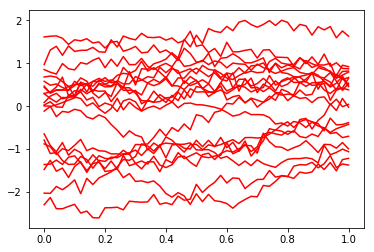

In [5]:
thin = np.arange(0,x.size,2)
xthin = x[thin]
#k2 = k.copy()
Kthin = k.K(xthin)
f_thin = f_samples[:,thin]
for ii in np.arange(20):
    plt.plot(xthin, f_thin[ii,:], 'r')

Now let's evaluate the likelihood of both the original curves, and the thinned values, both under the true model. 

In [6]:
like_thin = multivariate_normal.logpdf(f_thin, np.zeros(xthin.size), Kthin)
like_full = multivariate_normal.logpdf(f_samples, np.zeros(x.size), K)
rank_thin=np.argsort(like_thin)
rank_full=np.argsort(like_full)

print(like_thin)
print(like_full)

print(rank_full)
print(rank_thin)

[36.00052742 29.2701917  37.97852778 34.29222067 31.61886651 23.73725433
 29.9680918  23.95378455 26.30844146 35.84830282 37.20098503 35.65589218
 30.68032405 35.16762149 29.27241834 27.53899692 33.16397817 30.71633049
 34.01764836 24.71868515]
[84.70577065 68.49424875 80.08491374 68.61649528 69.53278658 59.60662978
 70.5050986  63.74891711 63.48757966 78.11834507 79.33167659 83.23060644
 69.05451339 88.48774254 62.85682913 57.59474344 71.45802554 59.28726485
 79.72680627 63.0808559 ]
[15 17  5 14 19  8  7  1  3 12  4  6 16  9 10 18  2 11  0 13]
[ 5  7 19  8 15  1 14  6 12 17  4 16 18  3 13 11  9  0 10  2]


The orderings of these likelihoods looks quite different, albeit that difference mainly comes in the middle values, and so the ordering is probably not very meaningful. For example, we can do a spearman rank correlation test to see if they are significantly different.

In [7]:
from scipy.stats import spearmanr
print(spearmanr(rank_full, rank_thin))

SpearmanrResult(correlation=0.048120300751879695, pvalue=0.8403389659546905)


Okay, upon reflection, perhaps this isn't a mystery at all. I don't know how

## Mystery 2
A constant function, even one far from zero, has higher probability under this model than any of the random samples. Below, I evaluate the probability of the constant curves y=0 and y=7. $y=0$ will have the highest probability, but I would have imagined the curve $y=7$ would have been highly unlikely under a N(0,1) model, and so I would expect this curve to be less likely than any of the random samples.

In [8]:
print(multivariate_normal.logpdf(np.zeros(x.size), np.zeros(x.size), K))
print(multivariate_normal.logpdf(np.zeros(x.size)+7, np.zeros(x.size), K))
multivariate_normal.logpdf(f_samples, np.zeros(x.size), K)

123.37738020080167
89.57861777500838


array([84.70577065, 68.49424875, 80.08491374, 68.61649528, 69.53278658,
       59.60662978, 70.5050986 , 63.74891711, 63.48757966, 78.11834507,
       79.33167659, 83.23060644, 69.05451339, 88.48774254, 62.85682913,
       57.59474344, 71.45802554, 59.28726485, 79.72680627, 63.0808559 ])

Text(0.5,1,'20 random samples from a $N(0, K)$ distribution plus a constant curve at $y=7$')

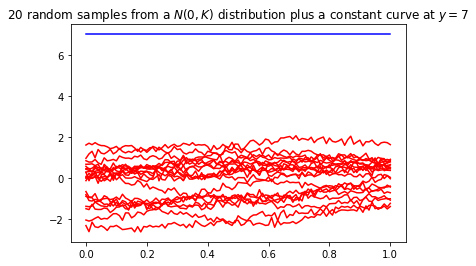

In [9]:

for ii in np.arange(20):
    plt.plot(x, f_samples[ii,:], 'r')
plt.plot(x, np.zeros(x.size)+7, 'b')
plt.title("20 random samples from a $N(0, K)$ distribution plus a constant curve at $y=7$")

As you can see, $y=7$ has a higher probability than any of the actual random samples from this model. Why is this?

In [10]:
x = np.linspace(0,1,101)[:,None]
k = GPy.kern.Matern32(1, lengthscale=0.1)+GPy.kern.White(1, variance=0.00001)
K = k.K(x)
v,_ = np.linalg.eig(K)
print(np.min(v))
f_samples = np.random.multivariate_normal(np.zeros(x.size), K, 20)

print(multivariate_normal.logpdf(np.zeros(x.size)+7, np.zeros(x.size), K))
multivariate_normal.logpdf(f_samples, np.zeros(x.size), K)

0.00044084594509753635
10.67442717223011


array([ 92.35587913,  85.95794778, 102.29655043,  99.95466749,
        99.48038996,  89.55942954,  97.8127451 ,  80.40947558,
        85.90340006,  97.91215965,  91.58140925,  93.05095565,
        96.58008086,  92.60519561,  69.36547922,  93.60768145,
        94.93050993,  89.33718592,  92.80561478,  82.35204872])

The problem doesn't go away if I use a very small nugget variance (if I make the nugget variance too small then I get numerical instability issues like you would expect).

If I make the length-scale shorter (or the nugget variance large), then we get the result we'd expect (that the probability of seeing $y=7$ is very unlikely)


*Questions:* 
- Is this me just being daft somehow? Could it still be numerical issues?
- If I'm not being daft (and I don't see how I am), then is this interesting? No one I've yet asked has an explanation of what is happening?